Text(0.5, 1.0, 'Image 2')

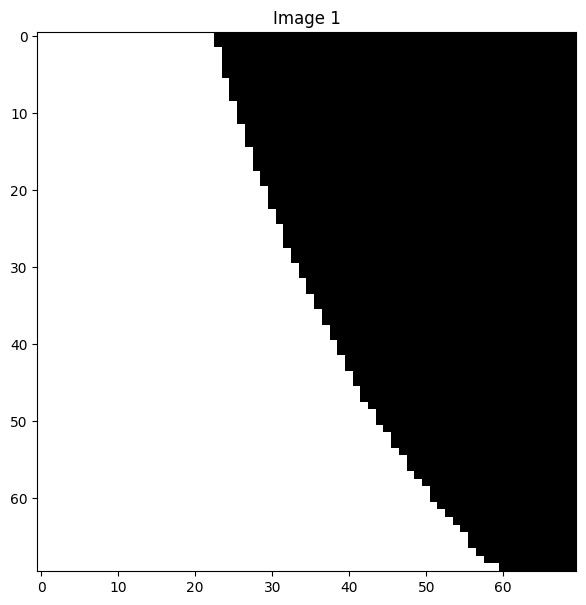

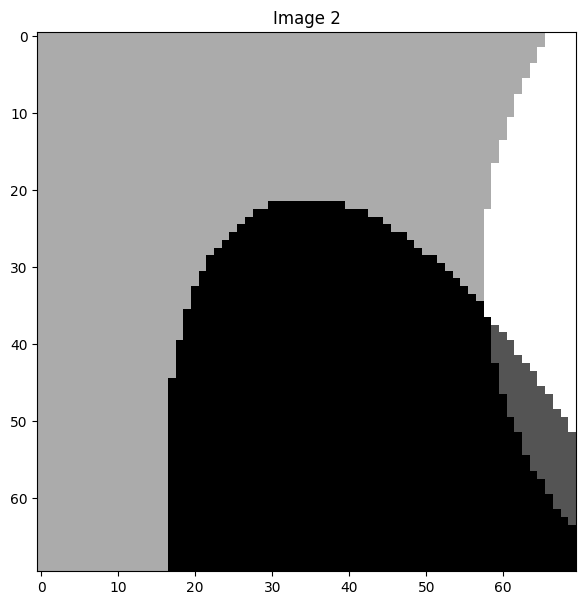

In [2]:
import torch
from QBI_radon import Radon, get_pad_width

# import libraries
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon
plt.rcParams["figure.figsize"] = [7, 7]
import numpy as np
import time

img = shepp_logan_phantom()
img1 = img[200:270, 100:170]
img2 = img[100:170, 100:170]
# define some constants
batch_size = 1
n_angles = 512

# imshow img1 and img2
plt.figure()
plt.imshow(img1, cmap='gray')
plt.title('Image 1')
plt.figure()
plt.imshow(img2, cmap='gray')
plt.title('Image 2')

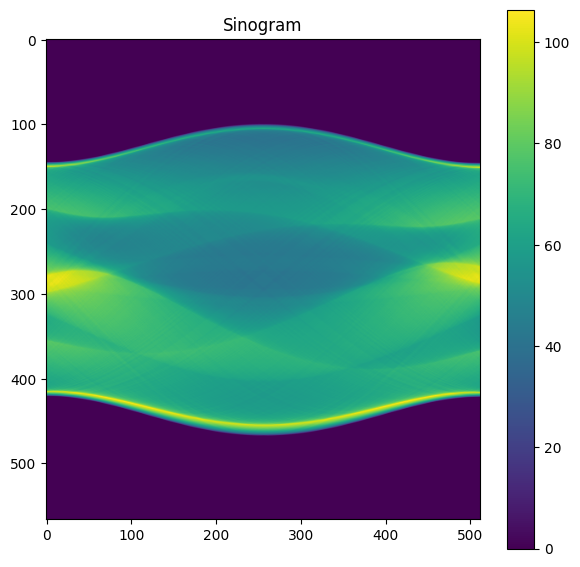

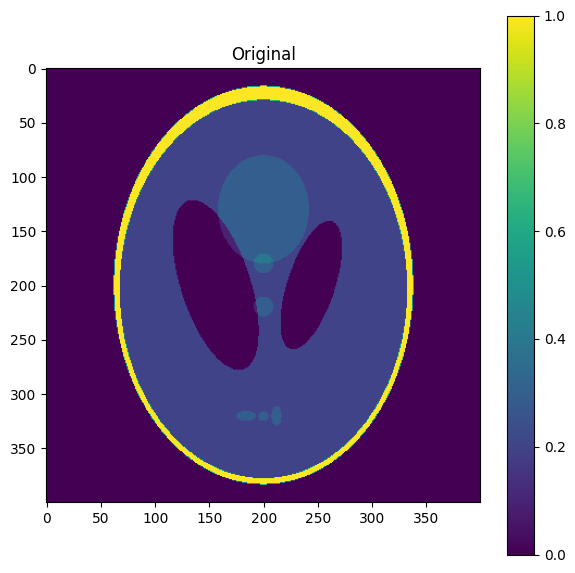

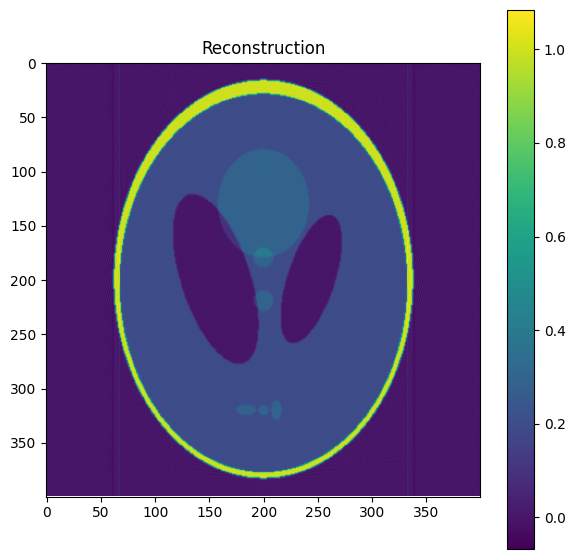

FBP error (skimage): 0.1279370504879091


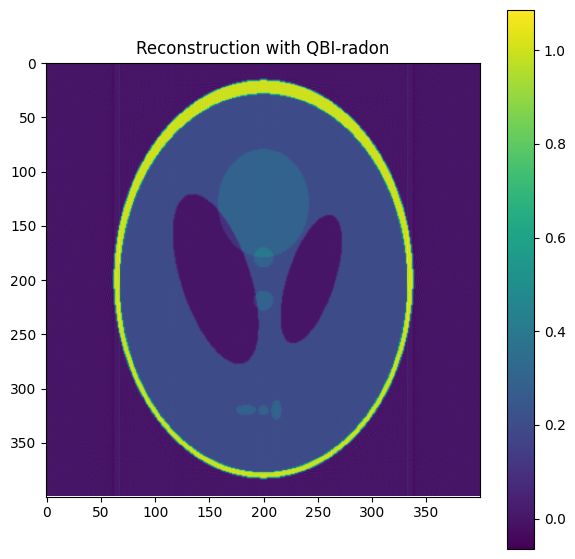

FBP Relative Error (QBI-radon): 0.12774083018302917


In [3]:
from skimage.transform import radon, iradon
import torch
import numpy as np
import matplotlib.pyplot as plt
from QBI_radon import Radon  # Assuming this is the import path

# ------------------------------
# Define some constants
# ------------------------------
batch_size = 1
n_angles = 512  # Number of projection angles
device = torch.device("cuda")  # Use GPU for QBI-radon

# ------------------------------
# Generate sinogram using skimage (CPU)
# ------------------------------
# Compute the Radon transform (sinogram) of the input image using skimage
sinogram = radon(img, theta=np.linspace(0, 180, n_angles), circle=False)

# Visualize the sinogram
plt.imshow(sinogram)
plt.colorbar()
plt.title("Sinogram")
plt.show()

# Display the original image
plt.imshow(img)
plt.colorbar()
plt.title("Original")
plt.show()

# ------------------------------
# Reconstruct image using Filtered Backprojection (FBP) in skimage (CPU)
# ------------------------------
# Apply the inverse Radon transform (FBP) with a ramp filter
reconstructed_skimage = iradon(
    sinogram, theta=np.linspace(0, 180, n_angles), filter_name="ramp", circle=False
)

# Display the reconstructed image
plt.imshow(reconstructed_skimage)
plt.colorbar()
plt.title("Reconstruction")
plt.show()

# Compute and print the relative reconstruction error
print("FBP error (skimage):", np.linalg.norm(img - reconstructed_skimage) / np.linalg.norm(reconstructed_skimage))

# ------------------------------
# Reconstruct image using QBI-radon (GPU + PyTorch)
# ------------------------------
# Convert image to PyTorch tensor and move to GPU
image = torch.FloatTensor(img).to(device)[None, None]  # Shape: [1, 1, H, W]

# Initialize the Radon transform operator from QBI-radon
radon_op = Radon(
    thetas=np.linspace(0, np.pi, n_angles),  # Angles in radians
    circle=False,
    device=device,
    filter_name="ramp"
)

# Perform forward projection to generate sinogram (differentiable, on GPU)
sinogram = radon_op.forward(image)

# Apply filtered backprojection to reconstruct the image (on GPU)
reconstructed_24 = radon_op.filter_backprojection(sinogram)

# Display the reconstructed image from QBI-radon
plt.imshow(reconstructed_24[0, 0].cpu().numpy())
plt.colorbar()
plt.title("Reconstruction with QBI-radon")
plt.show()

# Compute and print the relative reconstruction error for QBI-radon
print("FBP Relative Error (QBI-radon):", (torch.norm(image - reconstructed_24) / torch.norm(reconstructed_24)).item())

C:\Users\Predator\AppData\Local\Temp\ipykernel_1412\1853856643.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  image = torch.FloatTensor([img1, img2]).to(device)[:, None]


Radon time: 1.0186307430267334


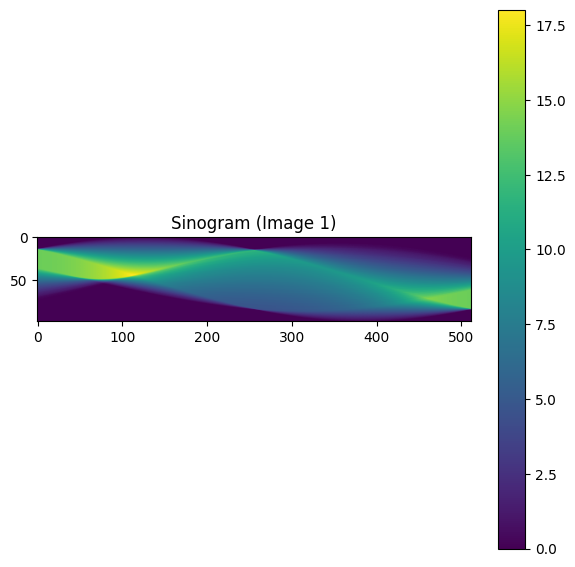

FBP time: 0.6285550594329834


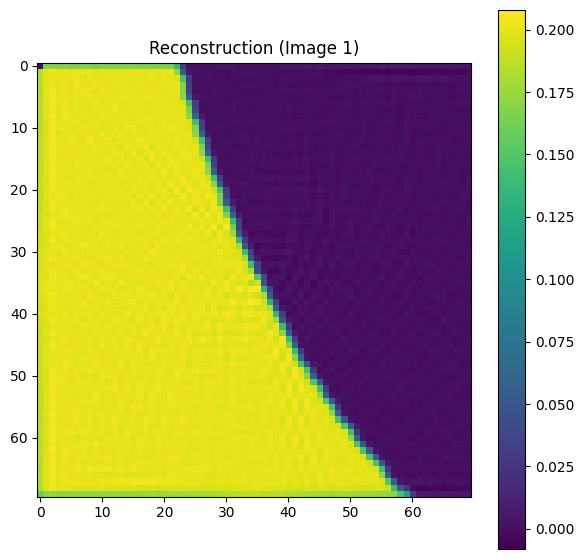

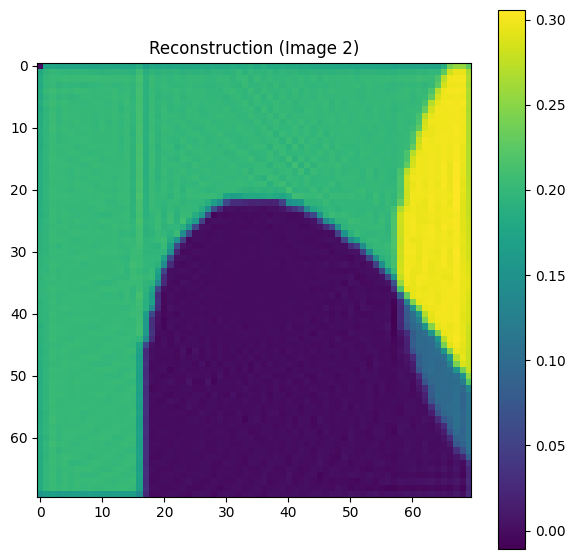

FBP Relative Error: 0.032488930970430374


In [4]:
# ------------------------------
# Setup
# ------------------------------
n_angles = 512  # Number of projection angles for Radon transform
device = torch.device("cuda")  # Use GPU for acceleration

# Create a batch of 2 images and move them to GPU
# Shape: [batch_size, 1, H, W]
batch_size = 2
image = torch.FloatTensor([img1, img2]).to(device)[:, None]
image_size = image.shape[-1]  # Assuming square images

# ------------------------------
# Initialize Radon operator
# ------------------------------
# Create Radon transform operator using evenly spaced angles in radians
radon_op = Radon(
    thetas=np.linspace(0, np.pi, n_angles),  # Angles from 0 to π
    circle=False,                            # Use full image (not cropped to circle)
    filter_name="ramp",                      # Use ramp filter for FBP
    device=device                            # Run operations on GPU
)

# ------------------------------
# Apply Radon transform (forward projection)
# ------------------------------
time_start = time.time()
sino = radon_op(image)  # Apply Radon transform in batch mode
print("Radon time:", time.time() - time_start)

# Visualize the sinogram of the first image in the batch
plt.imshow(sino[0, 0].cpu())
plt.colorbar()
plt.title("Sinogram (Image 1)")
plt.show()

# ------------------------------
# Apply Filtered Backprojection (inverse)
# ------------------------------
time_start = time.time()
reconstructed = radon_op.filter_backprojection(sino)  # Apply FBP
print("FBP time:", time.time() - time_start)

# ------------------------------
# Visualize Reconstructed Images
# ------------------------------
# Reconstructed image for batch 1
plt.imshow(reconstructed[0, 0].cpu())
plt.colorbar()
plt.title("Reconstruction (Image 1)")
plt.show()

# Reconstructed image for batch 2
plt.imshow(reconstructed[1, 0].cpu())
plt.colorbar()
plt.title("Reconstruction (Image 2)")
plt.show()

# ------------------------------
# Compute Relative Error
# ------------------------------
# Compute mean relative error across the batch
error = torch.norm(image - reconstructed) / (batch_size * torch.norm(reconstructed).item())
print("FBP Relative Error:", error.item())

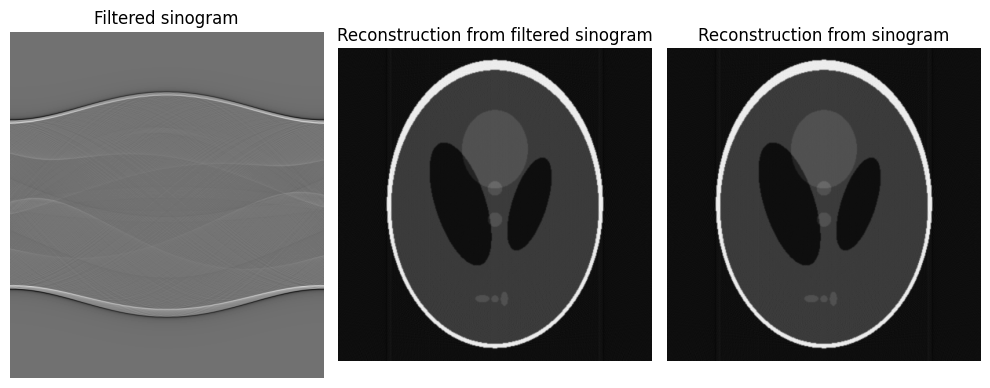

FBP error (filtered sinogram): 0.13140862533199407
FBP error (built-in filtering): 0.1245302240853769


In [5]:
from QBI_radon import Radon, ramp_filter_torch
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Apply ramp filter manually to the sinogram
# ------------------------------
# This creates a filtered version of the sinogram using QBI_radon's built-in ramp filter function
filtered_sinogram = ramp_filter_torch(sinogram, device=device)

# ------------------------------
# Initialize a Radon operator WITHOUT built-in filtering
# ------------------------------
# This operator is used to test reconstruction from a manually filtered sinogram
radon_op_no_filter = Radon(
    thetas=np.linspace(0, np.pi, n_angles),
    circle=False,
    device=device,
    filter_name=None  # No filtering done internally
)

# ------------------------------
# Reconstruct images
# ------------------------------
# Reconstruct image from the manually filtered sinogram
reconstructed_24_filtered = radon_op_no_filter.filter_backprojection(filtered_sinogram)

# Reconstruct image using the standard pipeline with built-in filtering
reconstructed_24 = radon_op.filter_backprojection(sinogram)

# ------------------------------
# Display results: Filtered sinogram & two reconstructions
# ------------------------------
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# Show manually filtered sinogram
ax[0].imshow(filtered_sinogram.cpu().numpy()[0, 0], cmap="gray")
ax[0].set_title("Filtered sinogram")
ax[0].axis("off")

# Show reconstruction from manually filtered sinogram
ax[1].imshow(reconstructed_24_filtered.cpu().numpy()[0, 0], cmap="gray")
ax[1].set_title("Reconstruction from filtered sinogram")
ax[1].axis("off")

# Show reconstruction using built-in filtering
ax[2].imshow(reconstructed_24.cpu().numpy()[0, 0], cmap="gray")
ax[2].set_title("Reconstruction from sinogram")
ax[2].axis("off")

plt.tight_layout()
plt.show()

# ------------------------------
# Compute and print reconstruction errors
# ------------------------------
# Compare both reconstructions to the original image (img), using relative L2 error
error_filtered = np.linalg.norm(img - reconstructed_24_filtered.cpu().numpy()[0, 0]) / np.linalg.norm(img)
error_unfiltered = np.linalg.norm(img - reconstructed_24.cpu().numpy()[0, 0]) / np.linalg.norm(img)

print("FBP error (filtered sinogram):", error_filtered)
print("FBP error (built-in filtering):", error_unfiltered)